In [10]:
import numpy as np
from CoolProp.CoolProp import PropsSI

In [11]:
def losses_arr(S_expected_arr, P1_arr, Ps_arr, xf_arr, xL_arr, Tf_arr, F_arr, V_arr):
    S_results = []
    Qp_results = []
    U_result = []
    Ues_result = []
    S_nhl_results=[]
    # Loop through each set of input values
    for i in range(len(S_expected_arr)):
        S_expected = S_expected_arr[i]
        P1 = P1_arr[i]
        Ps = Ps_arr[i]
        xf = xf_arr[i]
        xL = xL_arr[i]
        Tf = Tf_arr[i]
        F = F_arr[i]
        V = V_arr[i]
        
        if xf > 0 and xL > 0:
            L = (xf * F) / xL
            V=F-L
        else:
            L = F - V
        # Boiling point of water at P1
        Tw = PropsSI('T', 'P', P1, 'Q', 0, 'Water') - 273.15
        
        # Boiling point elevation (BPE) and T1 calculation
        A = 8.325E-2 + (1.883E-4 * Tw) + (4.02E-6 * (Tw**2))
        B = -7.625e-4 + (9.02e-5 * Tw) - (5.2e-7 * (Tw**2))
        C = 1.522E-4 - (3E-6 * Tw) - (3E-8 * (Tw**2))
        BPE = A * xf + (B * (xf**2)) + (C * (xf**3))
        T1 = (Tw + BPE) + 273.15  # Boiling point of the solution at P1 (K)
        
        # Calculate enthalpies for vapor, liquid, and feed
        H_liq = PropsSI('H', 'P', Ps, 'Q', 0, 'Water')
        H_vap = PropsSI('H', 'P', Ps, 'Q', 1, 'Water')
        l_heat = H_vap - H_liq  # Latent heat of water vapor at Ps (J/kg)
        
        Hv = PropsSI('H', 'P', P1, 'Q', 1, 'Water')  # Produced vapor at P1, T1 without solute
        hf = PropsSI('H', 'T', Tf, 'P', 101325, 'Water')
        hL = PropsSI('H', 'T', T1, 'Q', 0, 'Water')  # Liquor enthalpy at T1, xL
        
        # Adjust hf and hL using solute concentration
        a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = (-2.348e4, 3.152e5, 2.803e6, -1.446e5, 7.826e03, -4.417e1, 2.139e-1, -1.991e4, 2.778e4, 9.728e1)
        sF = xf / 100
        sL = xL / 100
        tf = Tf - 273.15
        t1 = T1 - 273.15
        
        # Correction for hf and hL using solute and temperature dependence
        hf =hf- (sF * (a1 + (a2 * sF) + (a3 * (sF**2)) + (a4 * (sF**3)) + (a5 * tf) + (a6 * (tf**2)) + (a7 * (tf**3)) + (a8 * tf * sF) + (a9 * tf * (sF**2)) + (a10 * sF * (tf**2))))
        hL =hL- (sL * (a1 + (a2 * sL) + (a3 * (sL**2)) + (a4 * (sL**3)) + (a5 * t1) + (a6 * (t1**2)) + (a7 * (t1**3)) + (a8 * t1 * sL) + (a9 * t1 * (sL**2)) + (a10 * sL * (t1**2))))
        
        # Energy balance calculations
        Qp = (S_expected * l_heat) - (L * hL + V * Hv - F * hf)
        S = ((L * hL + V * Hv - F * hf)+(8113.58*1000)) / l_heat
        S_nhl=(L * hL + V * Hv - F * hf) / l_heat
        Ts= PropsSI('T', 'P', Ps, 'Q', 0, 'Water')  #Boiling point of pure water at Ps (K)
        Ar=3054
        U=(S*l_heat)/(Ar*(Ts-T1))
        Ues=(S_expected*l_heat)/(Ar*(Ts-T1))
        S_results.append(S)
        Qp_results.append(Qp)
        U_result.append(U)
        Ues_result.append(Ues)
        S_nhl_results.append(S_nhl)
    
    # Convert results to numpy arrays for easy manipulation
    S_results = np.array(S_results)
    Qp_results = np.array(Qp_results)
    S_nhl_results = np.array(S_nhl_results)
    U_result=np.array(U_result)
    Ues_result=np.array(Ues_result)
    
    return S_results, S_nhl_results,Qp_results,U_result,Ues_result


In [12]:
#Experimental data in array to execute all at once 
F_arr = np.array([14.02, 18.04])
Tf_arr = np.array([341.30, 325.15])
P1_arr = np.array([75190.00, 57242.13])
Ps_arr = np.array([109663.79, 109663.8])
xf_arr = np.array([0, 2.87])
xL_arr = np.array([0, 5.57])
V_arr = np.array([9.78, 10.24])
S_expected_arr = np.array([12.8,14.92])
#Apply function
S_results,S_nhl, Q_results,U_result,Ues_result = losses_arr(S_expected_arr, P1_arr, Ps_arr, xf_arr, xL_arr, Tf_arr, F_arr, V_arr)


In [13]:
#Print the results
print(f"Steam Mass: {S_results} kg")
print(f"Steam Mass (no heat loss): {S_nhl} kg")
print(f"Heat Losses : {Q_results/1000} kJ")
print(f"Overall Heat Transfer Coefficient (U) (model): {U_result} J/K*cm²")
print(f"Overall Heat Transfer Coefficient (U) (exp): {Ues_result} J/K*cm²")
prom = np.mean(Q_results/1000)
desv = np.std(Q_results/1000)
print("Mean Q_p: {:.2f}".format(prom))
print("Standard deviation Q_p: {:.2f}".format(desv))
tra=prom/(20*60)
print("Heat loss per second (kJ/s): {:.5f}".format(tra))

Steam Mass: [14.12227499 13.59772361] kg
Steam Mass (no heat loss): [10.5171436   9.99259221] kg
Heat Losses : [ 5137.71510929 11089.44801967] kJ
Overall Heat Transfer Coefficient (U) (model): [1002.6209893   586.13293208] J/K*cm²
Overall Heat Transfer Coefficient (U) (exp): [908.74513281 643.12995285] J/K*cm²
Mean Q_p: 8113.58
Standard deviation Q_p: 2975.87
Heat loss per second (kJ/s): 6.76132


In [15]:
#Relative error to S_expected
e_nhl=abs(S_nhl-S_expected_arr)*100/S_expected_arr
e_heat_loss=abs(S_results-S_expected_arr)*100/S_expected_arr
print(f"No heat loss error in steam mass calculation: {e_nhl} %")
print(f"Heat loss error in steam mass calculation: {e_heat_loss} %")

No heat loss error in steam mass calculation: [17.83481561 33.02552136] %
Heat loss error in steam mass calculation: [10.33027337  8.86244227] %


In [16]:
#Relative error S_calculated
e_nhl=abs(S_nhl-S_expected_arr)*100/S_nhl
e_heat_loss=abs(S_results-S_expected_arr)*100/S_results
print(f"No heat loss error in steam mass calculation: {e_nhl} %")
print(f"Heat loss error in steam mass calculation: {e_heat_loss} %")

No heat loss error in steam mass calculation: [21.70604951 49.31060611] %
Heat loss error in steam mass calculation: [9.36304521 9.72424814] %


In [17]:
Hv = PropsSI('H', 'P', 57242.13, 'Q', 1, 'Water')  # Produced vapor at P1, T1 without solute
hf = PropsSI('H', 'T', 325, 'P', 74000, 'Water')
hL = PropsSI('H', 'T', 357.87, 'Q', 0, 'Water')  # Liquor enthalpy at T1, xL
Hv/1000

2650.8706611904468

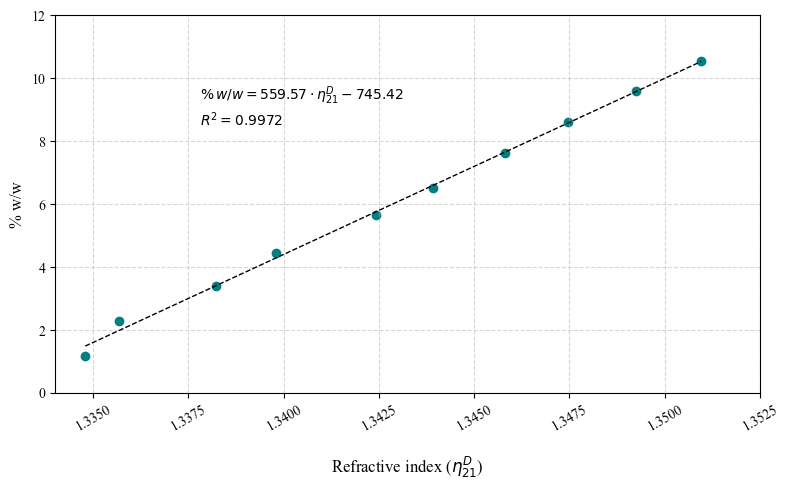

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
plt.rcParams["font.family"] = "Times New Roman"
y= np.array([1.16555181351171,2.29311911543484,3.41347201659389,4.45871709670465,5.66429063464015,6.51588232738018,7.61392235220737,8.61398219925352,9.59264126149803,10.5438043119376])
x=np.array([1.33479,1.335675,1.33822,1.339785,1.342415,1.34391,1.345815,1.34745,1.34925,1.350955])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x, y, color='teal', edgecolor='teal')
ax.plot(x, line, 'k--', linewidth=1)

# Add regression equation and R²
eq_text = (
    rf"$\%\,w/w = {slope:.2f} \cdot \eta_{{21}}^{{D}} {intercept:.2f}$" + "\n" +
    rf"$R^2 = {r_value**2:.4f}$"
)
ax.text(1.3378, 8.5, eq_text, fontsize=10)

# Axis labels
ax.set_xlabel(r"Refractive index ($\eta_{21}^{D}$)", fontsize=12,labelpad=15)
ax.set_ylabel("% w/w", fontsize=12)

# Set axis limits
ax.set_xlim(1.33400, 1.3525)
ax.set_ylim(0, 12)

# Rotate x-ticks if needed
plt.xticks(rotation=30)

# Show grid
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()